# Two Object Tracking

### Summary of notebook

* <b> Simulation of the two object tracking </b>

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import numpy as np
from matplotlib import pylab as plt
from mpl_toolkits import mplot3d
from canonical_gaussian import CanonicalGaussian as CG
from gaussian_mixture import GaussianMixtureModel as GMM
from calc_traj import calc_traj
from range_doppler import *
from util import *

np.set_printoptions(precision=2)

## Target information

In [2]:
names, p, v, w = load_clubs('clubs.csv')

cpi = 100e-3
T = 5
t_sim = np.arange(0, T, cpi)

t1, p1, v1 = calc_traj(p[0, :], v[0, :], w[0, :], t_sim)
t2, p2, v2 = calc_traj(p[-1, :], v[-1, :], w[-1, :], t_sim)

In [3]:
sensor_locations = np.array([[-10, 28.5, 1], [-15, 30.3, 3],
                             [200, 30, 1.5], [220, -31, 2],
                             [-30, 0, 0.5], [150, 10, 0.6]])

rd_1 = range_doppler(sensor_locations, p1, v1)
pm_1 = multilateration(sensor_locations, rd_1[:, :, 1])
vm_1 = determine_velocity(t1, pm_1, rd_1[:, :, 0])

rd_2 = range_doppler(sensor_locations, p2, v2)
pm_2 = multilateration(sensor_locations, rd_2[:, :, 1])
vm_2 = determine_velocity(t2, pm_2, rd_2[:, :, 0])

## The Kalman Filter Model

Used for both the initial test and the two object tracking scenario.

In [4]:
N = 6
M, _ = p1.shape

dt = cpi
g = 9.81

sigma_r = 2.5
sigma_q = 10

### Motion and measurement models

In [5]:
A = np.identity(N)
A[0, 3] = A[1, 4] = A[2, 5] = dt 

B = np.zeros((N, N))
B[2, 2] = B[5, 5] = 1

R = np.identity(N)*sigma_r

C = np.identity(N)
Q = np.identity(N)*sigma_q

u = np.zeros((6, 1))
u[2] = -0.5*g*(dt**2)
u[5] = -g*dt

### Priors

In [6]:
#Object 1
mu0_1 = np.zeros((N, 1))
mu0_1[3:, :] = v[0, :].reshape(3, 1)

sig0_1 = np.identity(N)
g0_1 = -0.5*(mu0_1.T)@(mu0_1) -3*np.log(2*np.pi)

#Object 2
mu0_2 = np.zeros((N, 1))
mu0_2[3:, :] = v[0, :].reshape(3, 1)

sig0_2 = np.identity(N)
g0_2 = -0.5*(mu0_2.T)@(mu0_2) -3*np.log(2*np.pi)

## Linear Kalman Filtering

This is really just extended testing.

### Creating the model

In [7]:
z_t = np.empty((M, N))

z_t[:, :3] = pm_1
z_t[:, 3:] = vm_1

In [8]:
R_in = np.linalg.inv(R)
P_pred = np.bmat([[R_in, -(R_in)@(A)], [-(A.T)@(R_in), (A.T)@(R_in)@(A)]])
M_pred = np.zeros((2*N, 1))
M_pred[:N, :] = (B)@(u)

h_pred = (P_pred)@(M_pred)
g_pred = -0.5*(M_pred.T)@(P_pred)@(M_pred) -0.5*np.log( np.linalg.det(2*np.pi*R))

In [9]:
Q_in = np.linalg.inv(Q)
P_meas = np.bmat([[(C.T)@(Q_in)@(C), -(C.T)@(Q_in)], [-(Q_in)@(C), Q_in]])

h_meas = np.zeros((2*N, 1))
g_meas = -0.5*np.log( np.linalg.det(2*np.pi*Q))

In [10]:
L, _ = z_t.shape 

X = np.arange(0, L)
Z = np.arange(L-1, 2*L-1)

In [11]:
C_X = [CG([X[0]], [N], mu0_1, sig0_1, g0_1)]
C_Z = [None]

for i in np.arange(1, L):
    C_X.append(CG([X[i], X[i-1]], [N, N], h_pred, P_pred, g_pred))
    C_Z.append(CG([X[i], Z[i]], [N, N], h_meas, P_meas, g_meas))

### The Kalman Filter algorithm: Gaussian belief propagation

In [12]:
predict = [C_X[0]]
mean = np.zeros((N, L))

for i in np.arange(1, L):
    C_Z[i].introduce_evidence([Z[i]], z_t[i, :])
    marg = (predict[i-1]*C_X[i]).marginalize([X[i-1]])
    predict.append(marg*C_Z[i])
    
    mean[:, i] = (np.linalg.inv(predict[i]._prec)@(predict[i]._info)).reshape((N, ))

In [13]:
p_e = mean[:3, :]
v_e = mean[3:, :]

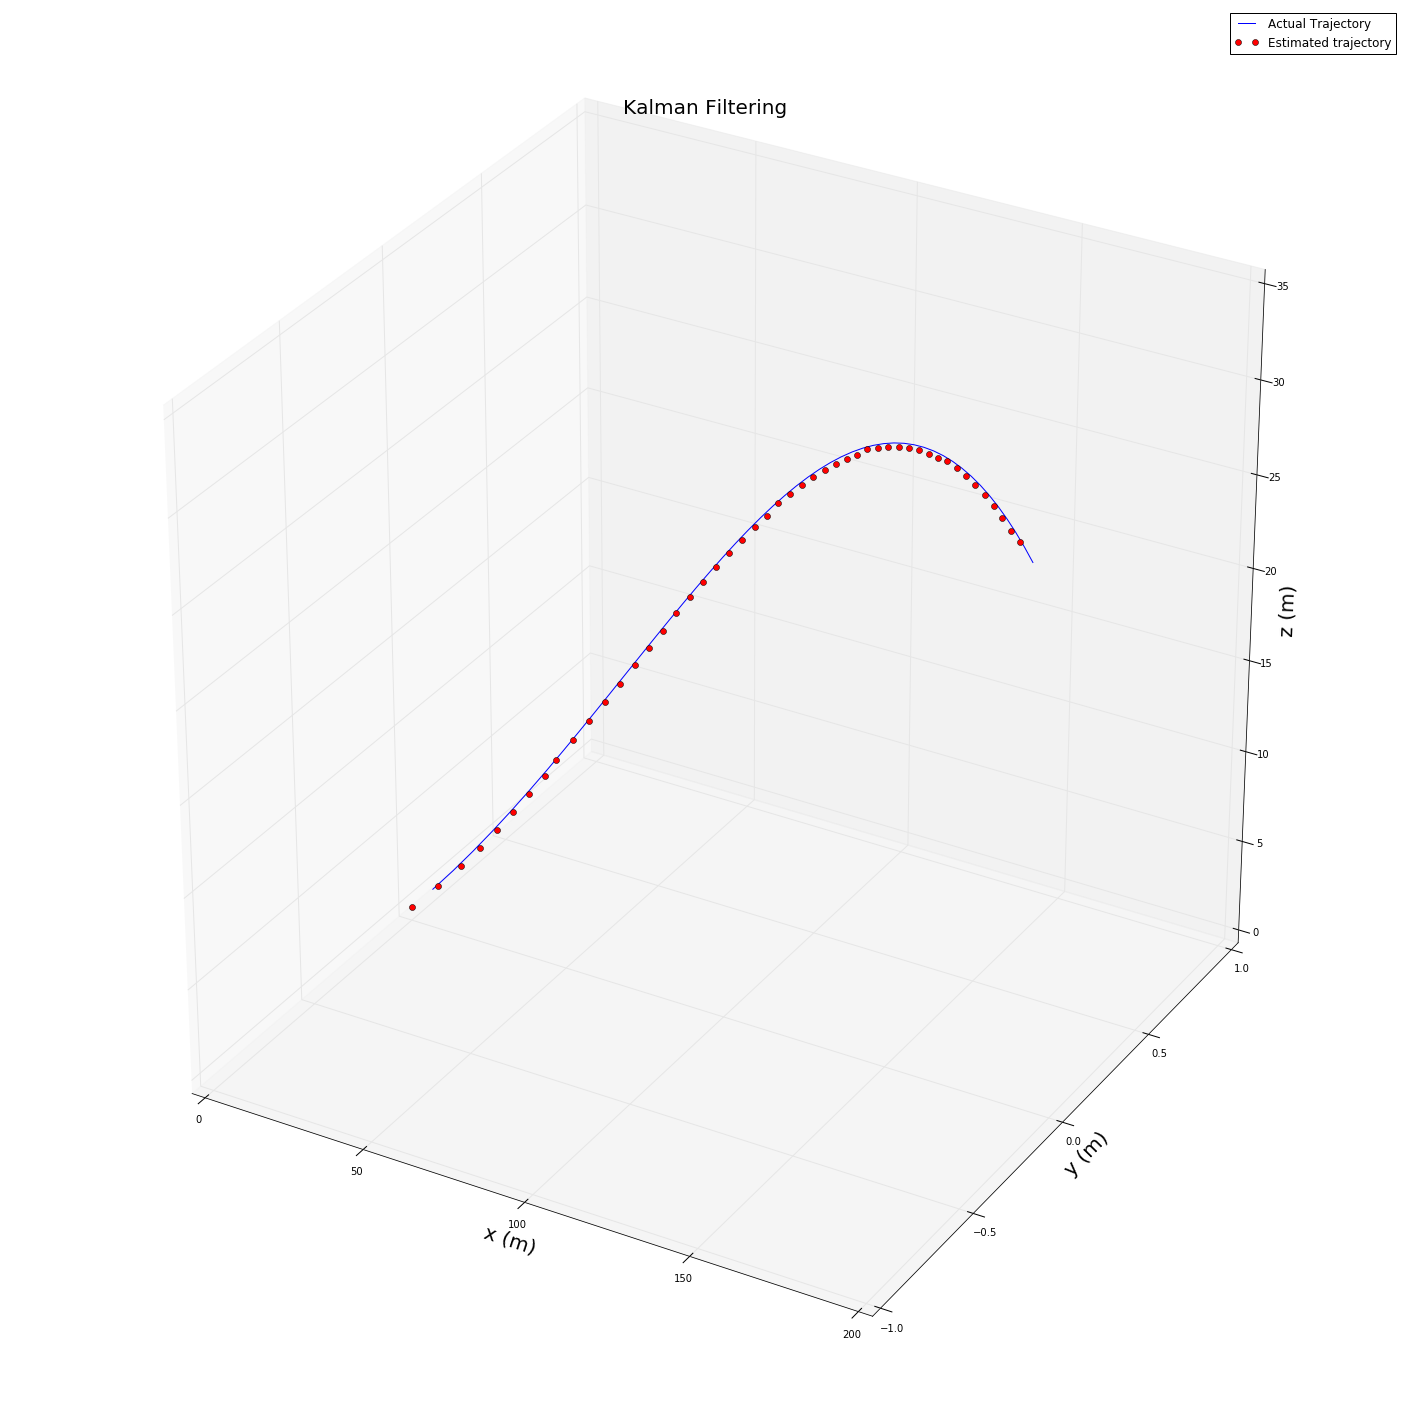

In [14]:
fig  = plt.figure(figsize=(25, 25))
ax = plt.axes(projection='3d')

ax.plot(p1[:, 0], p1[:, 1], p1[:, 2])
ax.plot(p_e[0, :], p_e[1, :], p_e[2, :], 'or')
ax.set_xlabel('x (m)', fontsize = '20')
ax.set_ylabel('y (m)', fontsize = '20')
ax.set_zlabel('z (m)', fontsize = '20')
ax.set_title('Kalman Filtering', fontsize = '20')
ax.set_ylim([-1, 1])
ax.legend(['Actual Trajectory', 'Estimated trajectory'])
plt.show()

In [15]:
D = 100

t = np.linspace(0, 2*np.pi, D)
xz = np.array([[np.cos(t)], [np.sin(t)]]).reshape((2, D))

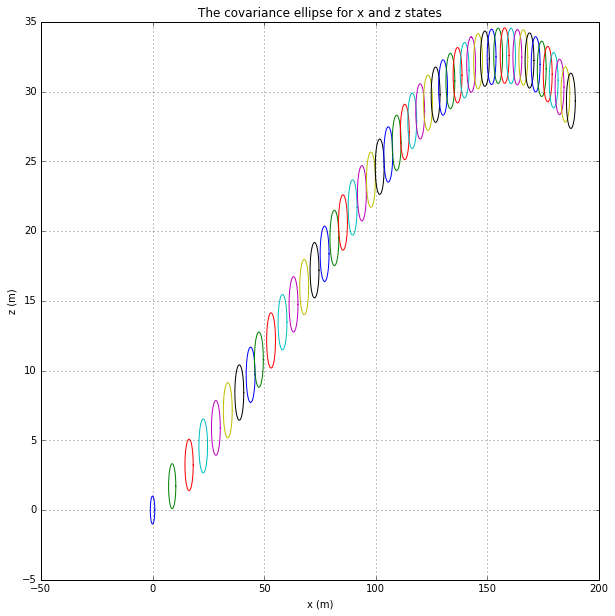

In [16]:
plt.figure(figsize= (10, 10))

for p in predict:
    p._vars = [1, 2, 3, 4]
    p._dims = [1, 1, 1, 3]
    
    c = p.marginalize([2, 4])
    
    cov = np.linalg.inv(c._prec)
    mu = (cov)@(c._info)
    
    U, S, _ = np.linalg.svd(cov)
    L = np.diag(np.sqrt(S))
    
    ellipse = np.dot((U)@(L), xz) + mu
    plt.plot(ellipse[0, :], ellipse[1, :])

plt.xlabel('x (m)')
plt.ylabel('z (m)')
plt.grid(True)
plt.title('The covariance ellipse for x and z states')
plt.show()

## Two object tracking

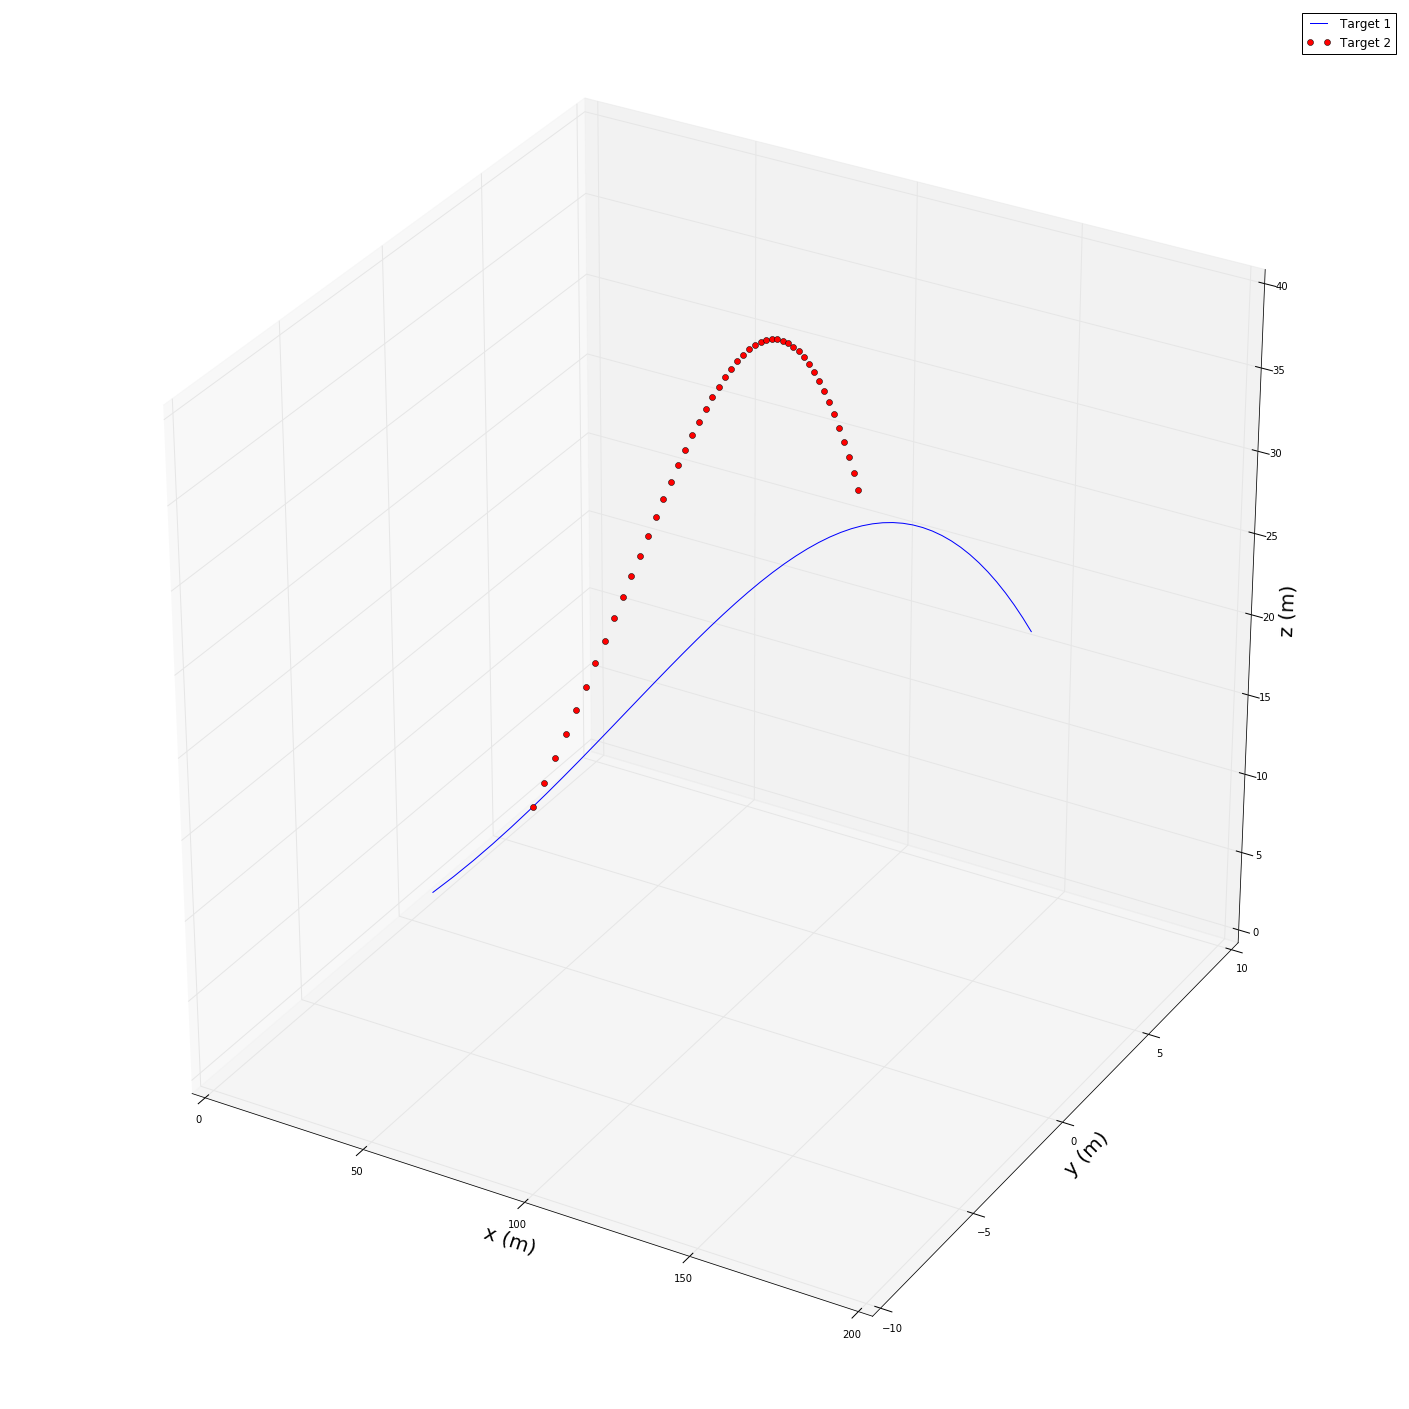

In [17]:
fig  = plt.figure(figsize=(25, 25))
ax = plt.axes(projection='3d')

ax.plot(p1[:, 0], p1[:, 1], p1[:, 2])
ax.plot(p2[:, 0], p2[:, 1], p2[:, 2], 'or')
ax.set_xlabel('x (m)', fontsize = '20')
ax.set_ylabel('y (m)', fontsize = '20')
ax.set_zlabel('z (m)', fontsize = '20')
ax.set_title('', fontsize = '20')
ax.set_ylim([-10, 10])
ax.legend(['Target 1', 'Target 2'])
plt.show()

In [18]:
L = 10

X_1 = np.arange(0, L).tolist()
X_2 = np.arange(L, 2*L).tolist()
Z_1 = np.arange(2*L, 3*L).tolist()
Z_2 = np.arange(3*L, 4*L).tolist()

z_1 = np.empty((M, N))
z_1[:, :3] = pm_1
z_1[:, 3:] = vm_1

z_2 = np.empty((M, N))
z_2[:, :3] = pm_2
z_2[:, 3:] = vm_2

In [19]:
C_X = [CG([X_1[0]], [N], mu0_1, sig0_1, g0_1)*CG([X_2[0]], [N], mu0_2, sig0_2, g0_2)]

for i in np.arange(1, L):
    C_X.append(CG([X_1[i], X_1[i-1]], [N, N], h_pred, P_pred, g_pred)
               *CG([X_2[i], X_2[i-1]], [N, N], h_pred, P_pred, g_pred))

In [20]:
C_Z = [None]

Z_11 = CG([X_1[1], Z_1[1]], [N, N], h_meas, P_meas, g_meas)
Z_11.introduce_evidence([Z_1[1]], z_1[1, :])

Z_22 = CG([X_2[1], Z_2[1]], [N, N], h_meas, P_meas, g_meas)
Z_22.introduce_evidence([Z_2[1]], z_2[1, :])

C_Z.append(Z_11*Z_22)

In [21]:
for i in np.arange(2, L):
    Z_11 = CG([X_1[i], Z_1[i]], [N, N], h_meas, P_meas, g_meas)
    Z_11.introduce_evidence([Z_1[i]], z_1[i, :])
    
    Z_22 = CG([X_2[i], Z_2[i]], [N, N], h_meas, P_meas, g_meas)
    Z_22.introduce_evidence([Z_2[i]], z_2[i, :])
    
    Z_12 = CG([X_1[i], Z_2[i]], [N, N], h_meas, P_meas, g_meas)
    Z_12.introduce_evidence([Z_2[i]] ,z_2[i, :])
    
    Z_21 = CG([X_2[i], Z_1[i]], [N, N], h_meas, P_meas, g_meas)
    Z_21.introduce_evidence([Z_1[i]], z_1[i, :])
    
    C_Z.append(GMM([0.5*(Z_11*Z_22), 0.5*(Z_12*Z_21)]))

In [22]:
predict = [C_X[0]]

for i in np.arange(1, L):
    marg = (C_X[i]*predict[i-1]).marginalize([X_1[i-1], X_2[i-1]])
    predict.append(C_Z[i]*marg)

In [23]:
D = 100

t = np.linspace(0, 2*np.pi, D)
xz = np.array([[np.cos(t)], [np.sin(t)]]).reshape((2, D))

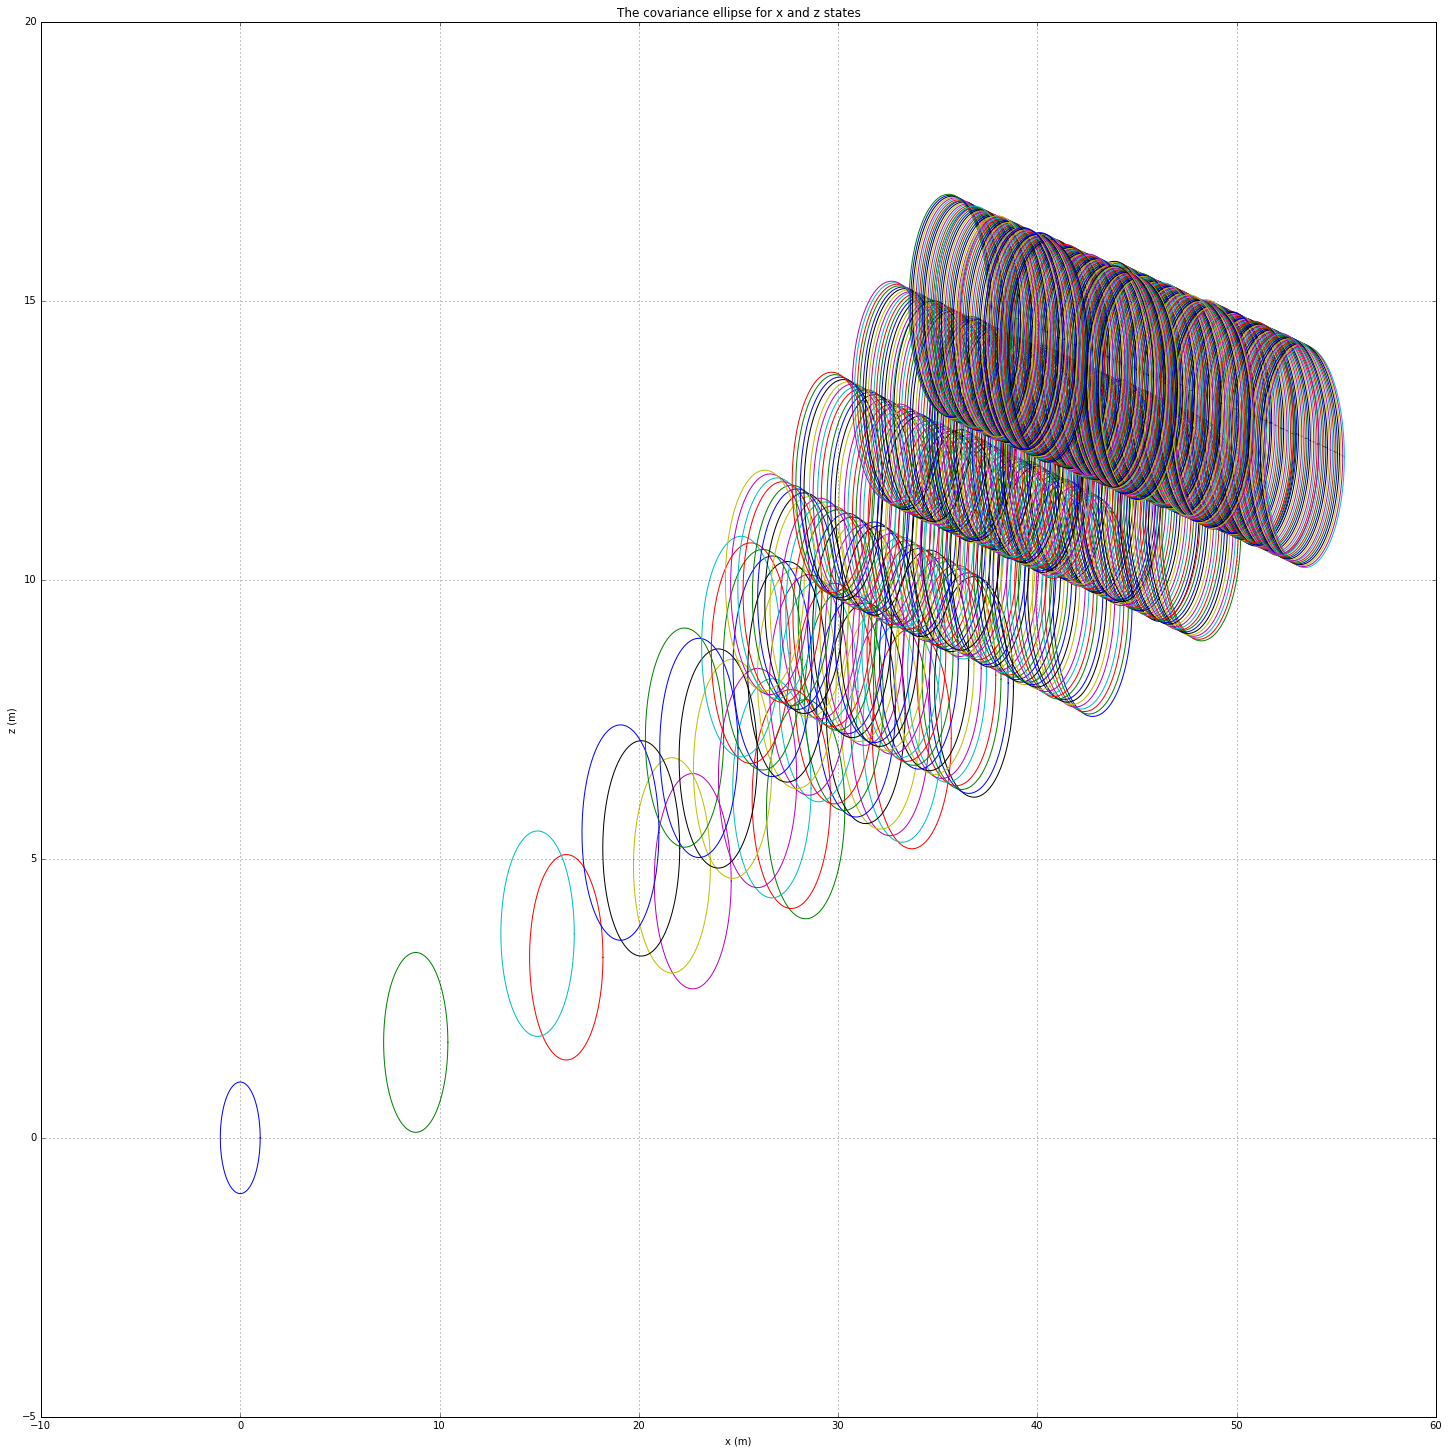

In [24]:
plt.figure(figsize= (25, 25))

for p in predict:
    
    if isinstance(p, GMM):
        mix = p._mix
    else:
        mix = [p]
        
    for m in mix:
    
        m._vars = [1, 2, 3, 4]
        m._dims = [1, 1, 1, 9]
    
        c = m.marginalize([2, 4])
    
        cov = np.linalg.inv(c._prec)
        mu = (cov)@(c._info)
    
        U, S, _ = np.linalg.svd(cov)
        L = np.diag(np.sqrt(S))
    
        ellipse = np.dot((U)@(L), xz) + mu
        plt.plot(ellipse[0, :], ellipse[1, :])

plt.xlabel('x (m)')
plt.ylabel('z (m)')
plt.grid(True)
plt.title('The covariance ellipse for x and z states')
plt.show()

In [25]:
print(list(range(0, 8)))

[0, 1, 2, 3, 4, 5, 6, 7]
